<h2 align=center>Vaibhav Sharma</h2>

In [2]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import Resize,ToTensor,Compose
import torchvision.transforms.functional as TF
from torchinfo import summary
import pickle as pk
import os
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.models import save_model, load_model
from PIL import Image
import tensorflow as tf

In [2]:
class TSegFrame:
    def __init__(self, img_path:str=None, mask_path:str=None, transforms=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.transforms = transforms

    def load_data(self, frame:dict(),num_imgs:int=100):
        img_files = os.listdir(self.img_path)

        names = []
        maskNames = []
        unames = []

        for idx, file in enumerate(img_files):
            unames.append(file.split('_')[0])

        unames = list(set(unames))

        for idx, name in enumerate(unames):
            names.append(name + '_t.png')
            maskNames.append(name + '_i2.png')

        img_addr = self.img_path + '/'
        mask_addr = self.mask_path + '/'

        for idx, name in enumerate(names):
            img = Image.open(img_addr + name, 'r')
            mask = Image.open(mask_addr + maskNames[idx],'r')

            img = self.transforms(img)
            mask = self.transforms(mask)
            mask = torch.argmax(mask,dim=0)

            frame['img'].append(img)
            frame['mask'].append(mask)

            if idx == num_imgs-1:
                return frame

        return frame

In [ ]:
frame = {
    'img' : [],
    'mask' : []
}
path = 'SIH_DATASET'
transforms = Compose([Resize(224),ToTensor()])
data = TSegFrame(img_path=path, mask_path=path, transforms=transforms)
frame = data.load_data(frame)

In [ ]:
with open("frame.pkl", "wb") as f:
    pk.dump(frame, f)

In [3]:
with open("frame-001.pkl", "rb") as f:
    frame = pk.load(f)

In [4]:
len(frame['img']), len(frame['mask'])

(5000, 5000)

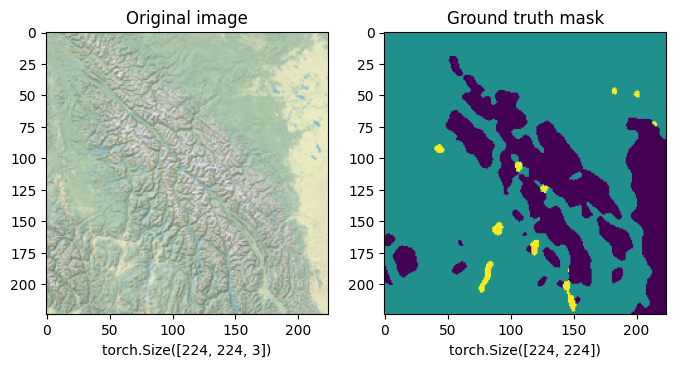

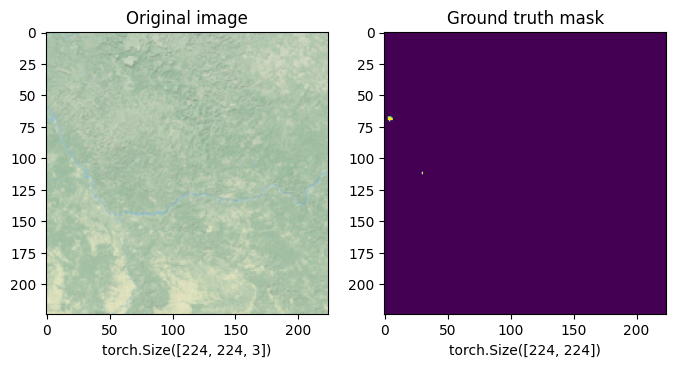

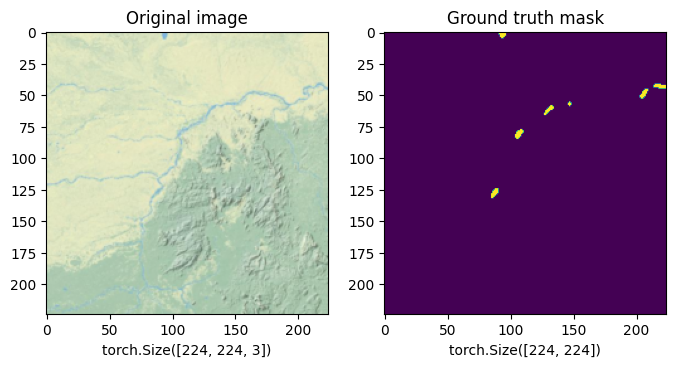

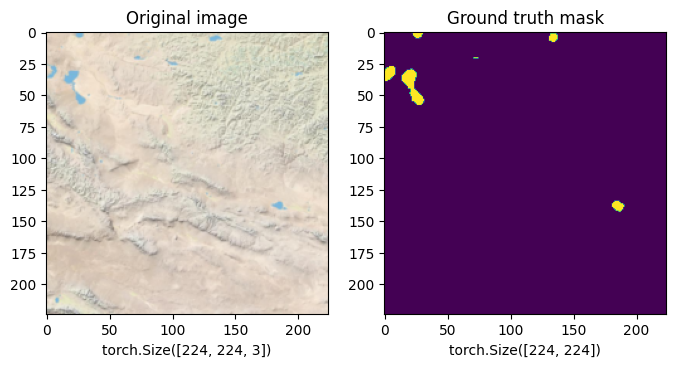

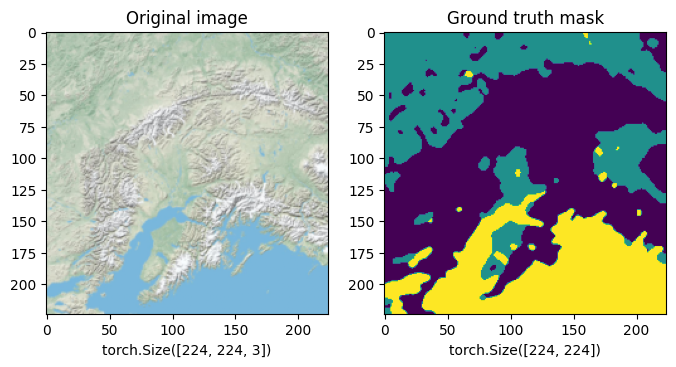

In [5]:
for i in range(5):
    plt.figure(figsize = (8, 12))
    img = frame['img'][i].permute(1,2,0)
    mask = frame['mask'][i]
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title('Original image')
    plt.xlabel(img.shape)
    plt.subplot(1,2,2)
    plt.imshow(mask)
    plt.title('Ground truth mask')
    plt.xlabel(mask.shape)

In [6]:
class TSegDataset(Dataset):
    def __init__(self, frame:dict()):
        self.frame = frame

    def __len__(self):
        return len(self.frame['img'])

    def __getitem__(self, idx):
        return self.frame['img'][idx], self.frame['mask'][idx]

In [7]:
tseg_data = TSegDataset(frame)

In [40]:
train_size = int(0.9 * len(tseg_data))
test_size = len(tseg_data) - train_size

train_data, test_data = random_split(tseg_data, [train_size, test_size])
len(train_data), len(test_data)

(4500, 500)

In [41]:
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=True)
len(train_loader), len(test_loader)

(282, 32)

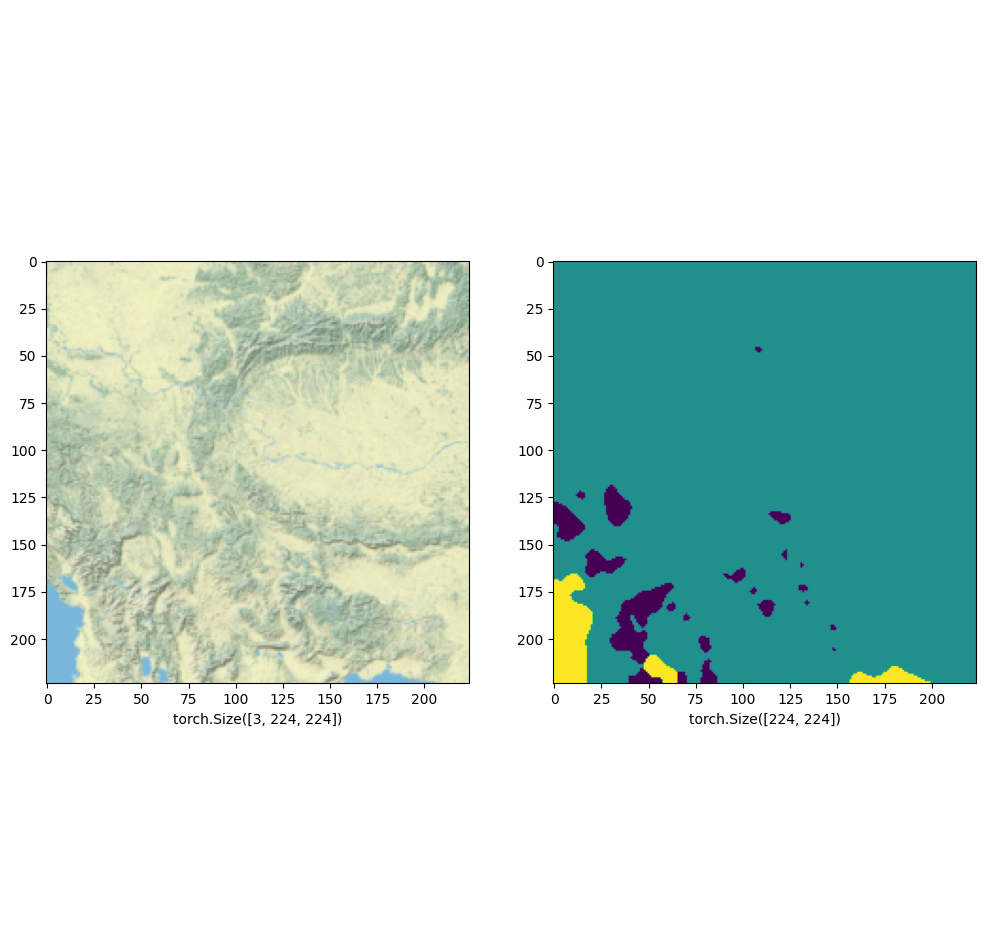

In [10]:
plt.figure(figsize = (12, 12))
plt.axis(False)
for idx, (image,mask) in enumerate(train_loader):
    plt.subplot(1,2,1)
    plt.imshow(image[0].permute(1,2,0))
    plt.xlabel(image[0].shape)
    plt.subplot(1,2,2)
    plt.imshow(mask[0])
    plt.xlabel(mask[0].shape)
    break

In [11]:
class DoubleConv(nn.Sequential):
    def __init__(self, in_channels:int, out_channels:int):
        layers = [nn.Conv2d(in_channels, out_channels, 3,1,1),
                 nn.BatchNorm2d(out_channels),
                 nn.ReLU(inplace=True),
                 nn.Conv2d(out_channels, out_channels,3,1,1),
                 nn.BatchNorm2d(out_channels),
                 nn.ReLU(inplace=True)]
        super().__init__(*layers)

In [13]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=7, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)


        self.encoders = nn.ModuleList()
        self.decoders = nn.ModuleList()

        # Encoder
        for feature in features:
            self.encoders.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Bottleneck
        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)

        # Decoder
        for feature in reversed(features):
            self.decoders.append(nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2))
            self.decoders.append(DoubleConv(feature * 2, feature))

        self.final_layer = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        # Encoder
        for encoder in self.encoders:
            x = encoder(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        # Decoder
        for i in range(0, len(self.decoders), 2):
            x = self.decoders[i](x)
            x = torch.cat((skip_connections[i // 2], x), dim=1)
            x = self.decoders[i + 1](x)

        x = self.final_layer(x)
        return x
    def save_model(self, file_path):
        """
        Save the model's state dictionary to an HDF5 file.

        Args:
            file_path (str): Path to the HDF5 file where the model should be saved.
        """
        torch.save(self.state_dict(), file_path)

    @classmethod
    def load_model(cls, file_path, in_channels=3, out_channels=7, features=[64, 128, 256, 512]):
        """
        Load a saved model from an HDF5 file and create an instance of the UNet class.

        Args:
            file_path (str): Path to the saved HDF5 file.
            in_channels (int): Number of input channels (default is 3).
            out_channels (int): Number of output channels (default is 7).
            features (list): List of feature dimensions for the encoder and decoder (default is [64, 128, 256, 512]).

        Returns:
            UNet: An instance of the UNet class with the loaded model weights.
        """
        model = cls(in_channels, out_channels, features)
        model.load_state_dict(torch.load(file_path))
        return model

In [14]:
model = UNet()
summary(model, (16,3,224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [16, 7, 224, 224]         --
├─ModuleList: 1-7                        --                        (recursive)
│    └─DoubleConv: 2-1                   [16, 64, 224, 224]        --
│    │    └─Conv2d: 3-1                  [16, 64, 224, 224]        1,792
│    │    └─BatchNorm2d: 3-2             [16, 64, 224, 224]        128
│    │    └─ReLU: 3-3                    [16, 64, 224, 224]        --
│    │    └─Conv2d: 3-4                  [16, 64, 224, 224]        36,928
│    │    └─BatchNorm2d: 3-5             [16, 64, 224, 224]        128
│    │    └─ReLU: 3-6                    [16, 64, 224, 224]        --
├─MaxPool2d: 1-2                         [16, 64, 112, 112]        --
├─ModuleList: 1-7                        --                        (recursive)
│    └─DoubleConv: 2-2                   [16, 128, 112, 112]       --
│    │    └─Conv2d: 3-7                  [16, 128, 112, 11

In [30]:
def accuracy_fn(loader, model, device='cuda'):
    num_correct = 0
    num_pixels = 0
    model.eval()

    with torch.inference_mode():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            preds = torch.sigmoid(model(X))
            preds = (preds > 0.5).float()
            print(preds.shape, y.shape)
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_coeff += (2*(preds*y).sum()) / ((preds + y).sum() + 1e-8)
    print(
        f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}"
    )
    print(f"Dice Score: {dice_score/len(loader)}")
    model.train()

In [31]:
epochs = 5
learning_rate = 1e-3

device = "cuda" if torch.cuda.is_available() else "cpu"
model = UNet().to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scaler = torch.cuda.amp.GradScaler()

In [ ]:
for epoch in range(epochs):
    print(f"Epoch: {epoch} \n --------------------------")

    train_loss = 0
    train_loop = tqdm(enumerate(train_loader),total=len(train_loader))
    for batch, (X, y) in train_loop:
        model.train()

        X, y = X.to(device), y.to(device)

        with torch.cuda.amp.autocast():
            preds = model(X)
            loss = loss_fn(preds, y)

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        train_loss += loss.item()

        train_loop.set_postfix(loss=loss.item())

    train_loss /= len(train_loader)

    test_loss= 0
    model.eval()
    test_loop = tqdm(enumerate(test_loader),total=len(test_loader))
    with torch.inference_mode():
        for idx, (X, y) in test_loop:
            X, y = X.to(device), y.to(device)

            y_preds = model(X)
            loss = loss_fn(y_preds, y)

            test_loss += loss.item()
            test_loop.set_postfix(loss=loss.item())

        test_loss /= len(test_loader)
    print(
        f"\nTraining Loss: {train_loss:.4f}, Test loss: {test_loss:.4f}"
    )
    if test_loss < 0.100000:
        break

In [32]:
test_imgs, test_masks = [] , []

for img, mask in random.sample(list(test_data),k=10):
    test_imgs.append(img)
    test_masks.append(mask)

In [ ]:
for i in range(5):
    plt.figure(figsize = (12, 12))
    plt.subplot(1,3,1)
    plt.imshow(test_imgs[i].permute(1,2,0))
    plt.title('Original image')
    plt.xlabel(test_imgs[i].shape)
    plt.subplot(1,3,2)
    plt.imshow(test_masks[i])
    plt.title('Ground truth mask')
    plt.xlabel(test_masks[i].shape)
    plt.subplot(1,3,3)
    pred = model(test_imgs[i].unsqueeze(0).to(device)).detach().cpu().squeeze(0).permute(1,2,0)
    plt.imshow(torch.argmax(pred,dim=2))
    plt.title('Predicted mask')
    plt.xlabel(pred.shape)

In [16]:
model_path = r'/content/drive/MyDrive/files/model.h5'

# Save the model
model.save_model(model_path)

print(f"Model saved to {model_path}")

Model saved to /content/drive/MyDrive/files/model.h5


In [ ]:
model = torch.load("model.h5", map_location='cpu')

In [51]:
def evaluate(self, dataloader, device):
    """
    Evaluate the model on a given dataloader and return accuracy.

    Args:
        dataloader (torch.utils.data.DataLoader): DataLoader for the validation/test dataset.
        device (str): Device on which to perform the evaluation (e.g., 'cuda' or 'cpu').

    Returns:
        float: The accuracy of the model on the dataset.
    """
    self.eval()
    total = 0

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = self(inputs)

            # Debugging: Examine outputs and targets
            # print("Outputs:", outputs)
            # print("Targets:", targets)

            # Assuming your output tensor has shape (batch_size, num_classes)
            _, predicted = torch.max(outputs, 1)
            total += len(targets.size())

    return total


In [53]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
total = evaluate(model, test_loader, device)
print(f"Accuracy on total dataset: {total}%")

Accuracy on total dataset: 96%


In [21]:
model = torch.load("model.h5", map_location='cpu')

In [24]:
import tensorflow as tf
import numpy as np

def evaluate1(self, dataloader):
    """
    Evaluate the model on a given dataloader and return accuracy.

    Args:
        dataloader (tf.data.Dataset): DataLoader for the validation/test dataset.

    Returns:
        float: The accuracy of the model on the dataset.
    """
    correct = 0
    total = 0

    for inputs, targets in dataloader:
        inputs, targets = tf.convert_to_tensor(inputs), tf.convert_to_tensor(targets)  # Convert NumPy arrays to TensorFlow tensors
        outputs = self(inputs)

        # Assuming your output tensor has shape (batch_size, num_classes)
        predicted = tf.argmax(outputs, axis=1)

        total += len(targets)
        correct += tf.reduce_sum(tf.cast(predicted == targets, tf.int32)).numpy()

    accuracy = 100 * correct / total
    return accuracy, correct, total


In [38]:
accuracy,correct,total=evaluate1(model,test_loader)
print(accuracy)

TypeError: conv2d() received an invalid combination of arguments - got (tensorflow.python.framework.ops.EagerTensor, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!tensorflow.python.framework.ops.EagerTensor!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!tensorflow.python.framework.ops.EagerTensor!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, int)
